<br><h1 style='text-align: center;'>Fake News</h1><br>

In [13]:
#!uv add pandas numpy matplotlib seaborn nltk

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", 300)
plt.style.use("ggplot")

In [15]:
filepath = "./data/news_sample.csv"

df = pd.read_csv(filepath, index_col="id").iloc[:, 1:]
df

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
id,,,,,,,,,,,,,,
141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39259,beforeitsnews.com,fake,http://beforeitsnews.com/economy/2017/12/priso...,"Prison for Rahm, God’s Work And Many Others\n\...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"Prison for Rahm, God’s Work And Many Others",NaN,NaN,[''],NaN,NaN,NaN
39468,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2017/11/4-useful-...,4 Useful Items for Your Tiny Home\n\nHeadline:...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,4 Useful Items for Your Tiny Home,Dimitry K,NaN,[''],NaN,NaN,NaN
39477,www.newsmax.com,NaN,https://www.newsmax.com/politics/michael-hayde...,Former CIA Director Michael Hayden said Thursd...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Michael Hayden: We Should Be 'Frightened' by T...,Todd Beamon,NaN,"['michael hayden', 'sthole countries', 'daca',...",President Donald Trump's reported remarks abou...,"Homeland Security, Trump Administration, Immig...",NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 141 to 39558
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   domain            250 non-null    object 
 1   type              238 non-null    object 
 2   url               250 non-null    object 
 3   content           250 non-null    object 
 4   scraped_at        250 non-null    object 
 5   inserted_at       250 non-null    object 
 6   updated_at        250 non-null    object 
 7   title             250 non-null    object 
 8   authors           170 non-null    object 
 9   keywords          0 non-null      float64
 10  meta_keywords     250 non-null    object 
 11  meta_description  54 non-null     object 
 12  tags              27 non-null     object 
 13  summary           0 non-null      float64
dtypes: float64(2), object(12)
memory usage: 29.3+ KB


In [17]:
df.drop(["keywords", "summary"], axis=1, inplace=True)
df = df.fillna("nan")
df["meta_keywords"] = df["meta_keywords"].replace("['']", "nan")

In [18]:
df.describe().drop(["count", "top"], axis=0)

,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,meta_keywords,meta_description,tags
unique,29,11,250,239,2,1,1,248,110,36,52,25
freq,155,155,1,9,197,250,250,2,80,211,196,223


In [19]:
# Helper function to collect tokens labeled as <OTHER>
def _collect_other(token, log):
    if log is not None:
        log.append(token)
    return "<OTHER>"

# clean function
def clean_text(doc: str, other_log: list | None = None):
    special_tokens = ["<NUM>", "<DATE>", "<EMAIL>", "<URL>"]
    lines = doc.split("\n")

    date_ptn = re.compile(r"[0-9]{1,2}[ -/]?[0-9]{1,2}[ -/]?[0-9]{2,4}")
    email_ptn = re.compile(r"[^ \n:;,.]+@[a-z0-9\.]+\.[^ \n:;,.]+")
    url_ptn = re.compile(r"[htps]{,5}:?/{,2}[a-zA-Z0-9]+\.[^ ]+")
    num_ptn = re.compile(r"[0-9][0-9,^]*\.?[0-9]*")

    out = []
    for line in lines:
        # Simplifying
        line = line.split()
        line = [x.replace("'", "") for x in line]  # Apostrophes
        line = [x.strip(",.;:()!@#$%^&*/[]-_\"?*+-=<>{} `~|¡ºª¢€ħðþ‘'“”\n\t–") for x in line]
        line = [x for x in line if len(x) > 0]  # Remove empty string (includes double spaces)
        line = [x.lower() for x in line]

        # Pattern matching
        line = re.sub(date_ptn, "<DATE>", " ".join(line))
        line = re.sub(email_ptn, "<EMAIL>", line)
        line = re.sub(url_ptn, "<URL>", line)
        # <NUM> last because dates,emails, and urls may contain numbers
        line = re.sub(num_ptn, "<NUM>", line).split()  

        # Joining back and adding <OTHER> token
        # Decided to keep word1-word2 as a new word
        line = " ".join(
            [
                x
                if x.replace("-", "").replace("'", "").isalpha()
                or x in special_tokens
                else _collect_other(x, other_log)
                for x in line
            ]
        )
        out.append(line)

    return "\n".join(out).replace("\n\n", "\n")
        

<br><br><br>
<h1 style='text-align : center;'>CHECK OTHER</h1>
<br><br><br>

In [20]:
from collections import Counter

other_tokens = []
for doc in df["content"].dropna().head(500):
    clean_text(doc, other_log=other_tokens)

other_counts = (
    pd.DataFrame(
        Counter(other_tokens).most_common(2000),
        columns=["token", "count"],
    )
)

print(f"Unique tokens mapped to <OTHER>: {len(other_counts)}")
other_counts

Unique tokens mapped to <OTHER>: 1120


,token,count
0,it’s,269
1,—,138
2,don’t,122
3,that’s,83
4,i’m,73
...,...,...
1115,disclosed…,1
1116,<NUM>/<NUM>th,1
1117,wait…,1
1118,doctor’s,1


In [21]:
# clean object cols
natural_language_cols = [
    "content",
    "title",
    "authors",
    "meta_keywords",
    "meta_description",
]
clean_nlc = df[natural_language_cols].apply(lambda x: [clean_text(c) for c in x])
for col in natural_language_cols:
    df[col] = clean_nlc[col]

df[df["meta_keywords"] != "nan"][natural_language_cols].head()

,content,title,authors,meta_keywords,meta_description
id,,,,,
1685,president trump right with rep robert lighthiz...,in calling out fake news donald trump engaged ...,hamilton strategies,fake news donald trump president trump vote tr...,stephen e strang author of god and donald trum...
8751,subscribe to canada free press for free\nfairn...,obama and redistribution of your wealth,joseph harris because without america there is...,conservative news conservative newspaper,news politics editorials commentary canada fre...
8792,president <OTHER> plan to continue deploying a...,ben cardin trumps new syria plan is illegal,joel gehrke,rex tillerson isis senate foreign relations be...,we are on the precipice of committing <URL> fo...
9101,something is wrong at newsweek and whoever is ...,newsweek fact check denies russian payments to...,becket adams,fake news clinton foundation becket adams soci...,whats the use of fact checking things that hav...
9272,american forces made one of their most effecti...,byron york <URL> ran out of ammo in attack on ...,byron york,isis national security the pentagon byron york...,of a group of <NUM> oil tankers used by the is...


In [22]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# nltk.download('stopwords')


# remove stop words
stop_words = list(set(stopwords.words("english")))
for col in natural_language_cols:
    df[col] = df[col].apply(
        lambda x: " ".join([word for word in x.split() if word not in stop_words])
    )


# stem
stemmer = PorterStemmer()
for col in natural_language_cols:
    df[col] = df[col].apply(lambda x: " ".join([stemmer.stem(w) for w in x.split()]))


df[natural_language_cols]

,content,title,authors,meta_keywords,meta_description
id,,,,,
141,sometim power christma make wild wonder thing ...,church congreg bring gift waitress work christ...,ruth harri,nan,nan
256,awaken <num> strand dna reconnect movi reader ...,awaken <num> strand dna reconnect movi,zurich time,nan,nan
700,never hike alon friday <other> fan film usa <d...,never hike alon friday <other> fan film full movi,nan,nan,never hike alon friday <other> fan film usa <d...
768,rare shark caught scientist left blunder answe...,elus alien sea caught scientist one first time...,alexand smith,nan,nan
791,donald trump unnerv abil abil creat realiti co...,<other> geniu poll complet result american bur...,gloria christi,nan,nan
...,...,...,...,...,...
39259,prison rahm <other> work mani other headlin bi...,prison rahm <other> work mani other,nan,nan,nan
39468,<num> use item tini home headlin bitcoin block...,<num> use item tini home,dimitri k,nan,nan
39477,former cia director michael hayden said thursd...,michael hayden frighten trump remark,todd beamon,michael hayden sthole countri daca haiti el sa...,presid donald trump report remark immigr certa...


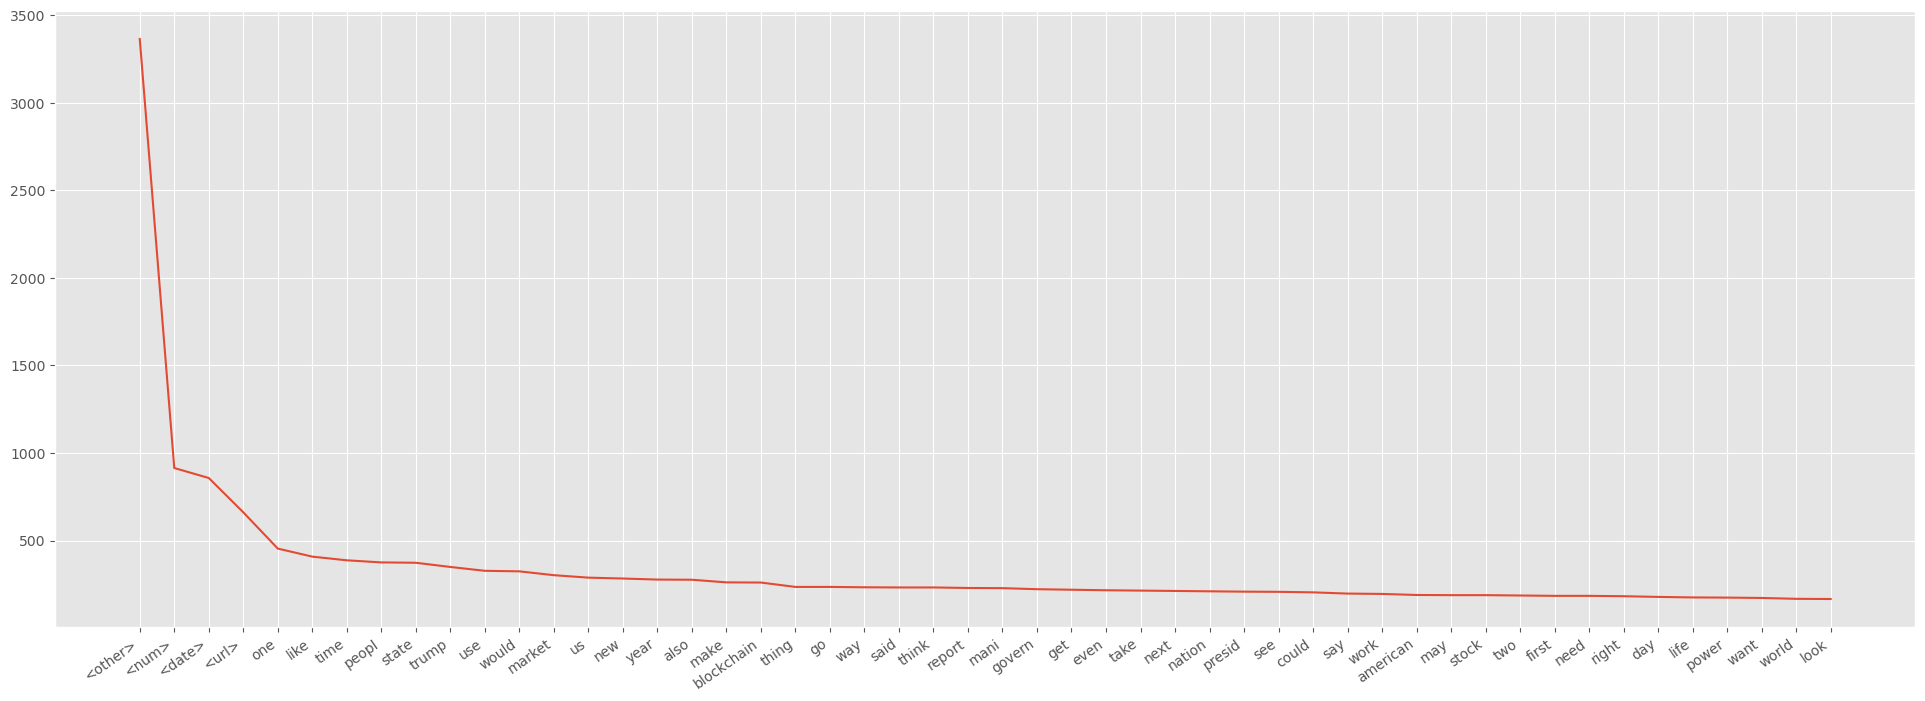

In [23]:
vocab = pd.Series(df[natural_language_cols].sum().sum().split()).value_counts().head(50)

plt.figure(figsize=(24, 8))
plt.plot(vocab.index, vocab.values)
plt.xticks(rotation=35, ha="right")
plt.show()